<div style='background-color: #fff7f7; border: 2px solid '>
    <font size="+2" color="green" ><b>🚗 Car brands classification 🚗</b></font>
</div>

In [ ]:
from google.colab import files
files.upload()

In [ ]:
! mkdir -p ~/.kaggle
! mv kaggle.json  ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! pip install -q kaggle

In [ ]:
import os, shutil

def data_yuklab_olish(saqlash_uchun_papka, data_nomi = "lentils"):

    data_nomlari = ["salaries", "exams", "college", "cars", "car_brands", "mall", "customers", "humanitarian", "apple_disease", "insects", "cars", "crop",
                    "rice_leaf_disease", "lentils", "brain", "fruits", "aeroscapes", "cardiac", "vehicles", "cloud", "skin_lesion", "comments", "3d_data"]

    assert data_nomi in data_nomlari, f"Mavjud bo'lgan dataset {data_nomlari} dan birini kiriting!"

    if data_nomi == "rice_leaf_disease": url = "kaggle datasets download -d killa92/rice-leaf-disease-classification-dataset"
    elif data_nomi == "lentils": url = "kaggle datasets download -d killa92/lentils-classification-dataset"
    elif data_nomi == "aeroscapes": url = "kaggle datasets download -d killa92/aerospaces-semantic-segmentation-dataset"
    elif data_nomi == "cardiac": url = "kaggle datasets download -d killa92/cardiac-semantic-segmentation-dataset"
    elif data_nomi == "brain": url = "kaggle datasets download -d killa92/brain-ct-tumor-classification-dataset"
    elif data_nomi == "fruits": url = "kaggle datasets download -d killa92/fruits-classification-dataset"
    elif data_nomi == "apple_disease": url = "kaggle datasets download -d killa92/apple-disease-dataset"
    elif data_nomi == "vehicles": url = "kaggle datasets download -d killa92/vehicle-detection-dataset"
    elif data_nomi == "cloud": url = "kaggle datasets download -d killa92/cloud-quality-images-classification-dataset"
    elif data_nomi == "insects": url = "kaggle datasets download -d killa92/arthropodia-semantic-segmentation-dataset"
    elif data_nomi == "cars": url = "kaggle datasets download -d killa92/car-detect-dataset"
    elif data_nomi == "skin_lesion": url = "kaggle datasets download -d killa92/skin-lesion-image-ham-classification"
    elif data_nomi == "crop": url = "kaggle datasets download -d killa92/crop-disease-image-classification-dataset"
    elif data_nomi == "comments": url = "kaggle datasets download -d killa92/comments-nlp-sentiment-analysis-dataset"
    elif data_nomi == "car_brands": url = "kaggle datasets download mohamedaziz15/cars-brands-in-egypt"
    elif data_nomi == "dog_breeds": url = "kaggle datasets download kabilan03/dogbreedclassification"
    elif data_nomi == "3d_data": url = "kaggle datasets download glxslzt/3cla-adni"

    # Dataset yuklab olinganligini tekshirish
    if os.path.isfile(f"{saqlash_uchun_papka}/{data_nomi}.csv") or os.path.isdir(f"{saqlash_uchun_papka}/{data_nomi}"): print(f"Dataset yuklab olingan. {saqlash_uchun_papka}/{data_nomi} papkasini ni tekshiring."); pass

    # Agar dataset yuklab olinmagan bo'lsa:
    else:
        # dataset nomini aniqlash
        ds_nomi = url.split("/")[-1]
        # data saqlanadigan yo'lakni belgilash
        full_path = f"{saqlash_uchun_papka}/{ds_nomi}"
        print(f"{data_nomi} dataset yuklanmoqda...")
        # Datasetni belgilangan yo'lakka yuklab olish
        os.system(f"{url} -p {full_path}")
        # Arxivdan chiqarib olish
        shutil.unpack_archive(f"{full_path}/{ds_nomi}.zip", f"{saqlash_uchun_papka}/{ds_nomi}")
        # Original arxiv faylni o'chirib tashlash
        os.remove(f"{full_path}/{ds_nomi}.zip")
        # Yuklab olingan datasetning nomini o'zgartirish
        os.rename(f"{saqlash_uchun_papka}/{ds_nomi}", f"{saqlash_uchun_papka}/{data_nomi}")
        print(f"Tanlangan dataset {saqlash_uchun_papka}/{data_nomi} papkasiga yuklab olindi!")

# Funktsiyadan foydalanish misoli
data_yuklab_olish(saqlash_uchun_papka = "datasets", data_nomi = "car_brands")

car_brands dataset yuklanmoqda...
Tanlangan dataset datasets/car_brands papkasiga yuklab olindi!


In [ ]:
import os, torch, random, shutil, numpy as np, pandas as pd
from glob import glob; from PIL import Image
Image.MAX_IMAGE_PIXELS = None
from torch.utils.data import random_split, Dataset, DataLoader
from torchvision import transforms as T


class CustomDataset(Dataset):

  def __init__(self, root, cls_names = None, transforms = None, im_files = [".jpg", ".jpeg", ".png"]):

    self.transform = transforms
    self.im_paths = (glob(f"{root}/*/*{[im_file for im_file in im_files]}"))

    self.im_paths = sorted(glob(f"{root}/*/*{[im_file for im_file in im_files]}"))

    self.cls_names, self.cls_counts, count = {} if not cls_names else cls_names, {}, 0


    for idx, im_path in enumerate(self.im_paths):
      cls_name = self.get_cls_name(im_path)
      if self.cls_names is not None:
        if cls_name not in self.cls_names:
          self.cls_names[cls_name] = count; count += 1

      if cls_name  not in self.cls_counts:
        self.cls_counts[cls_name] = 1
      else:
        self.cls_counts[cls_name] += 1


  def get_cls_name(self, path): return os.path.dirname(path).split("/")[-1]


  def __len__(self): return len(self.im_paths)

  def get_pos_neg_im_paths(self, qry_label):
    # positve image if same class as anchor/query
    pos_im_paths = [im_path for im_path in  self.im_paths if qry_label == self.get_cls_name(im_path)]

    # negative image if image is in a different class as query/anchor
    neg_im_paths = [im_path for im_path in self.im_paths if qry_label != self.get_cls_name(im_path)]


    # to choose random positive image (index)
    pos_rand_img = random.randint(a = 0, b = len(pos_im_paths) - 1)
    # to choose random negative image (index)
    neg_rand_img = random.randint(a = 0, b = len(neg_im_paths) - 1)


    return pos_im_paths[pos_rand_img], neg_im_paths[neg_rand_img]


  def read_im(self, path):

    im = Image.open(path)
    if im.mode == "P" and "transparency" in im.info:
      im = im.convert("RGBA")
    im = im.convert("RGB")

    return im

  def __getitem__(self, idx):

    im_path = self.im_paths[idx]
    qry_im = self.read_im(im_path)
    qry_label = self.get_cls_name(im_path)

    pos_im_path, neg_im_path = self.get_pos_neg_im_paths(qry_label = qry_label)
    pos_im, neg_im = self.read_im(pos_im_path), self.read_im(neg_im_path)

    qry_gt = self.cls_names[qry_label]
    neg_gt = self.cls_names[self.get_cls_name(neg_im_path)]

    if self.transform is not None:
      qry_im = self.transform(qry_im)
      pos_im = self.transform(pos_im)
      neg_im = self.transform(neg_im)

      data = {}

      data["qry_im"] = qry_im
      data["qry_gt"] = qry_gt
      data["pos_im"] = pos_im
      data["neg_im"] = neg_im
      data["neg_gt"] = neg_gt

      return data

def get_dls(root, transforms, bs, split = [0.9, 0.05, 0.05], ns = 4):

  ds = CustomDataset(root = root, transforms = transforms)
  cls_names = ds.cls_names
  cls_counts = ds.cls_counts
  total_len = len(ds)

  # Lenth of the each dataset(train, VAL, test)
  tr_len = int(total_len * split[0])
  vl_len = int(total_len * split[1])
  ts_len = total_len - tr_len - vl_len

  #  Splitting Datasets
  # tr_ds, vl_ds, ts_ds = random_split(dataset = ds, lengths = [tr_len, vl_len, ts_len])
  tr_ds, vl_ds, ts_ds = random_split(dataset = ds, lengths = [tr_len, vl_len, ts_len])


  # Creating a PyTorch DataLoaders
  tr_dl = DataLoader(dataset = tr_ds, batch_size = bs, shuffle = True, num_workers = ns)
  vl_dl = DataLoader(dataset = vl_ds, batch_size = bs, shuffle = False, num_workers = ns)
  ts_dl = DataLoader(dataset = ts_ds, batch_size = 1, shuffle = False, num_workers = ns)


  return tr_dl, vl_dl, ts_dl, cls_names, cls_counts

root = "/content/datasets/car_brands"
mean, std, size, bs = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225], 224, 20
tfs = T.Compose([T.ToTensor(), T.Resize(size = (size, size), antialias = False), T.Normalize(mean = mean, std = std)])
tr_dl, vl_dl, ts_dl, classes, cls_counts = get_dls(root = root, transforms = tfs, bs = bs)

# print(f" {len(tr_dl)} images in Train Dataloader "); print(f"{len(vl_dl)} images in Validation DataLoader"); print(f"{len(ts_dl)} images in Test Dataloader"); print(f"{classes} classes in the dataset")
print(len(tr_dl)); print(len(vl_dl)); print(len(ts_dl)); print(classes)


568
32
631
{'BMW': 0, 'Byd': 1, 'Chevrolet': 2, 'Ford': 3, 'Honda': 4, 'Hundai': 5, 'Mercedes-Benz': 6, 'Mitsubishi': 7, 'Renault': 8, 'Skoda': 9, 'Suzuki': 10, 'Toyota': 11, 'kia': 12, 'lada': 13, 'nissan': 14, 'volkswagen': 15}


<div style='background-color: #fff7f7; border: 2px solid '>
    <font size="+2" color="blue" ><b>📈  Data Analysis 📈</b></font>
</div>

Data analysis is in process...



<ipython-input-4-4f0f1099ddbb>:74: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(cls_names)


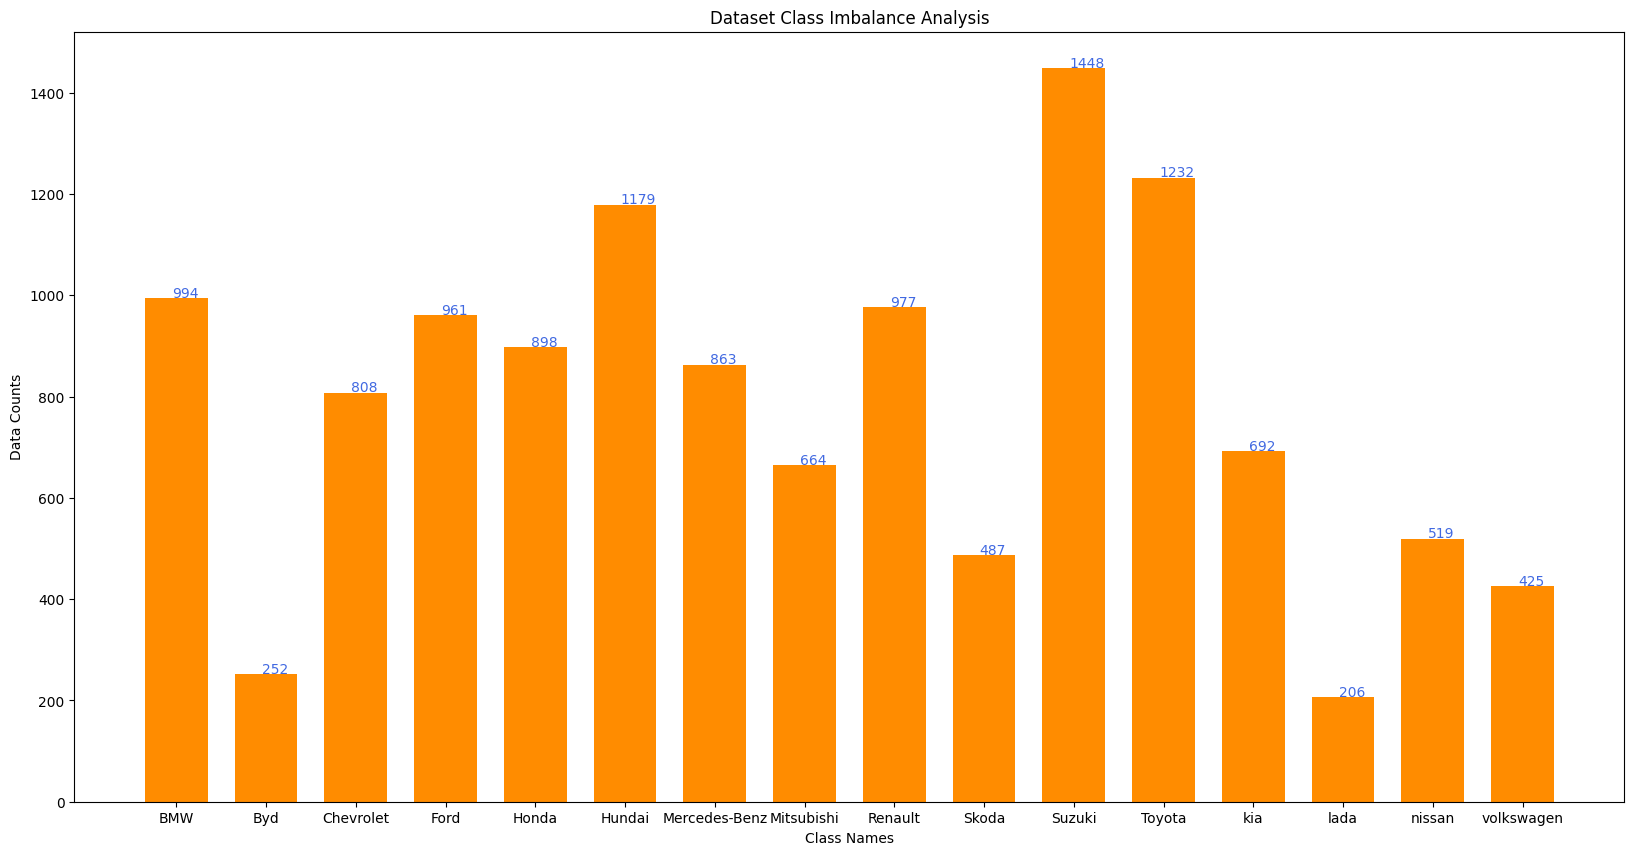

In [ ]:
from matplotlib import pyplot as plt

class Visualization:

    def __init__(self, vis_datas, n_ims, rows, cmap = None, cls_names = None, cls_counts = None, t_type = "rgb"):

        self.n_ims, self.rows = n_ims, rows
        self.t_type, self.cmap,  = t_type, cmap
        self.cls_names = cls_names

        data_names = ["train", "val", "test"]
        self.vis_datas = {data_names[i]: vis_datas[i] for i in range(len(vis_datas))}
        if isinstance(cls_counts, list): self.analysis_datas = {data_names[i]: cls_counts[i] for i in range(len(cls_counts))}
        else: self.analysis_datas = {"all": cls_counts}

    def tn2np(self, t):

        gray_tfs = T.Compose([T.Normalize(mean = [ 0.], std = [1/0.5]), T.Normalize(mean = [-0.5], std = [1])])
        rgb_tfs = T.Compose([T.Normalize(mean = [ 0., 0., 0. ], std = [ 1/0.229, 1/0.224, 1/0.225 ]), T.Normalize(mean = [ -0.485, -0.456, -0.406 ], std = [ 1., 1., 1. ])])

        invTrans = gray_tfs if self.t_type == "gray" else rgb_tfs

        return (invTrans(t) * 255).detach().squeeze().cpu().permute(1,2,0).numpy().astype(np.uint8) if self.t_type == "gray" else (invTrans(t) * 255).detach().cpu().permute(1,2,0).numpy().astype(np.uint8)

    def plot(self, rows, cols, count, im, title = "Original Image"):

        plt.subplot(rows, cols, count)
        plt.imshow(self.tn2np(im))
        plt.axis("off"); plt.title(title)

        return count + 1

    def vis(self, data, save_name):

        print(f"{save_name.upper()} Data Visualization is in process...\n")
        assert self.cmap in ["rgb", "gray"], "Please choose rgb or gray cmap"
        if self.cmap == "rgb": cmap = "viridis"
        cols = self.n_ims // self.rows; count = 1

        plt.figure(figsize = (25, 20))

        indices = [np.random.randint(low = 0, high = len(data) - 1) for _ in range(self.n_ims)]

        for idx, index in enumerate(indices):

            if count == self.n_ims + 1: break

            meta_data = data[index]
            qry_im, pos_im, neg_im, qry_lbl, neg_lbl = meta_data["qry_im"], meta_data["pos_im"], meta_data["neg_im"], meta_data["qry_gt"], meta_data["neg_gt"]

            # First Plot
            count = self.plot(self.rows, cols, count, im = qry_im, title = f"Query Image \n Class -> {self.cls_names[qry_lbl]}")

            # Second Plot
            count = self.plot(self.rows, cols, count, im = pos_im, title = f"Positive Image \n Class -> {self.cls_names[qry_lbl]}")

            # Third Plot
            count = self.plot(self.rows, cols, count, im = neg_im, title = f"Negative Image \n Class -> {self.cls_names[neg_lbl]}")

        plt.show()

    def data_analysis(self, cls_counts, save_name):

        print("Data analysis is in process...\n")

        width, text_width, text_height = 0.7, 0.05, 2
        cls_names = list(cls_counts.keys()); counts = list(cls_counts.values())

        _, ax = plt.subplots(figsize = (20, 10))
        indices = np.arange(len(counts))

        ax.bar(indices, counts, width, color = "darkorange")
        ax.set_xlabel("Class Names", color = "black")
        ax.set_xticklabels(cls_names)
        ax.set(xticks = indices, xticklabels = cls_names)
        ax.set_ylabel("Data Counts", color = "black")
        ax.set_title(f"Dataset Class Imbalance Analysis")

        for i, v in enumerate(counts): ax.text(i - text_width, v + text_height, str(v), color = "royalblue")

    def visualization(self): [self.vis(data.dataset, save_name) for (save_name, data) in self.vis_datas.items()]

    def analysis(self): [self.data_analysis(data, save_name) for (save_name, data) in self.analysis_datas.items()]

vis = Visualization(vis_datas = [tr_dl, vl_dl, ts_dl], n_ims = 18, rows = 6, cmap = "rgb", cls_names = list(classes.keys()), cls_counts = cls_counts)
vis.analysis()

<div style='background-color: #fff7f7; border: 2px solid '>
    <font size="+2" color="magenta" ><b>📊  Data Visualization 📊</b></font>
</div>

TRAIN Data Visualization is in process...



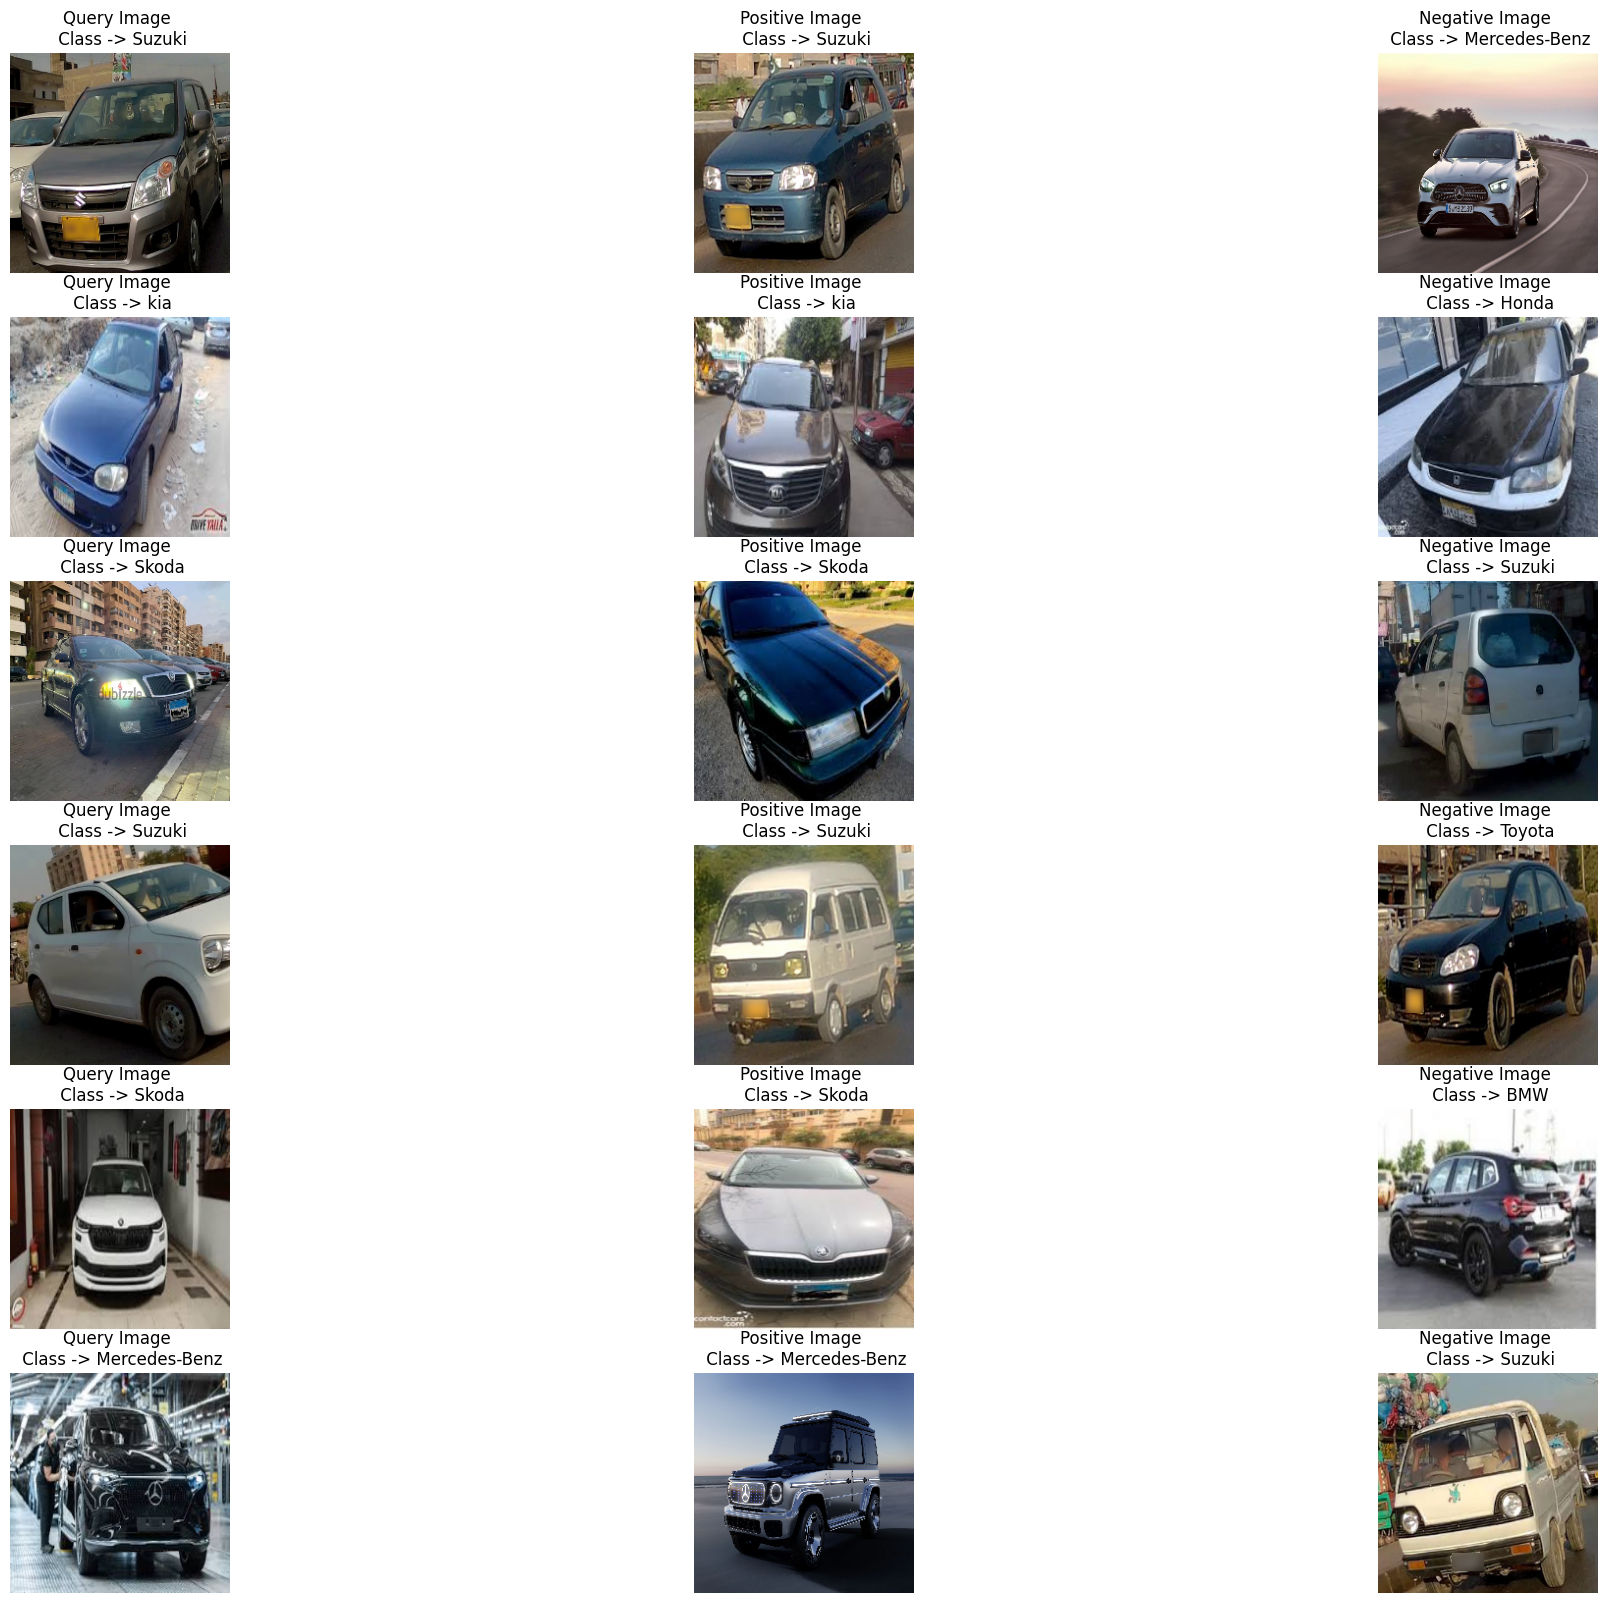

VAL Data Visualization is in process...



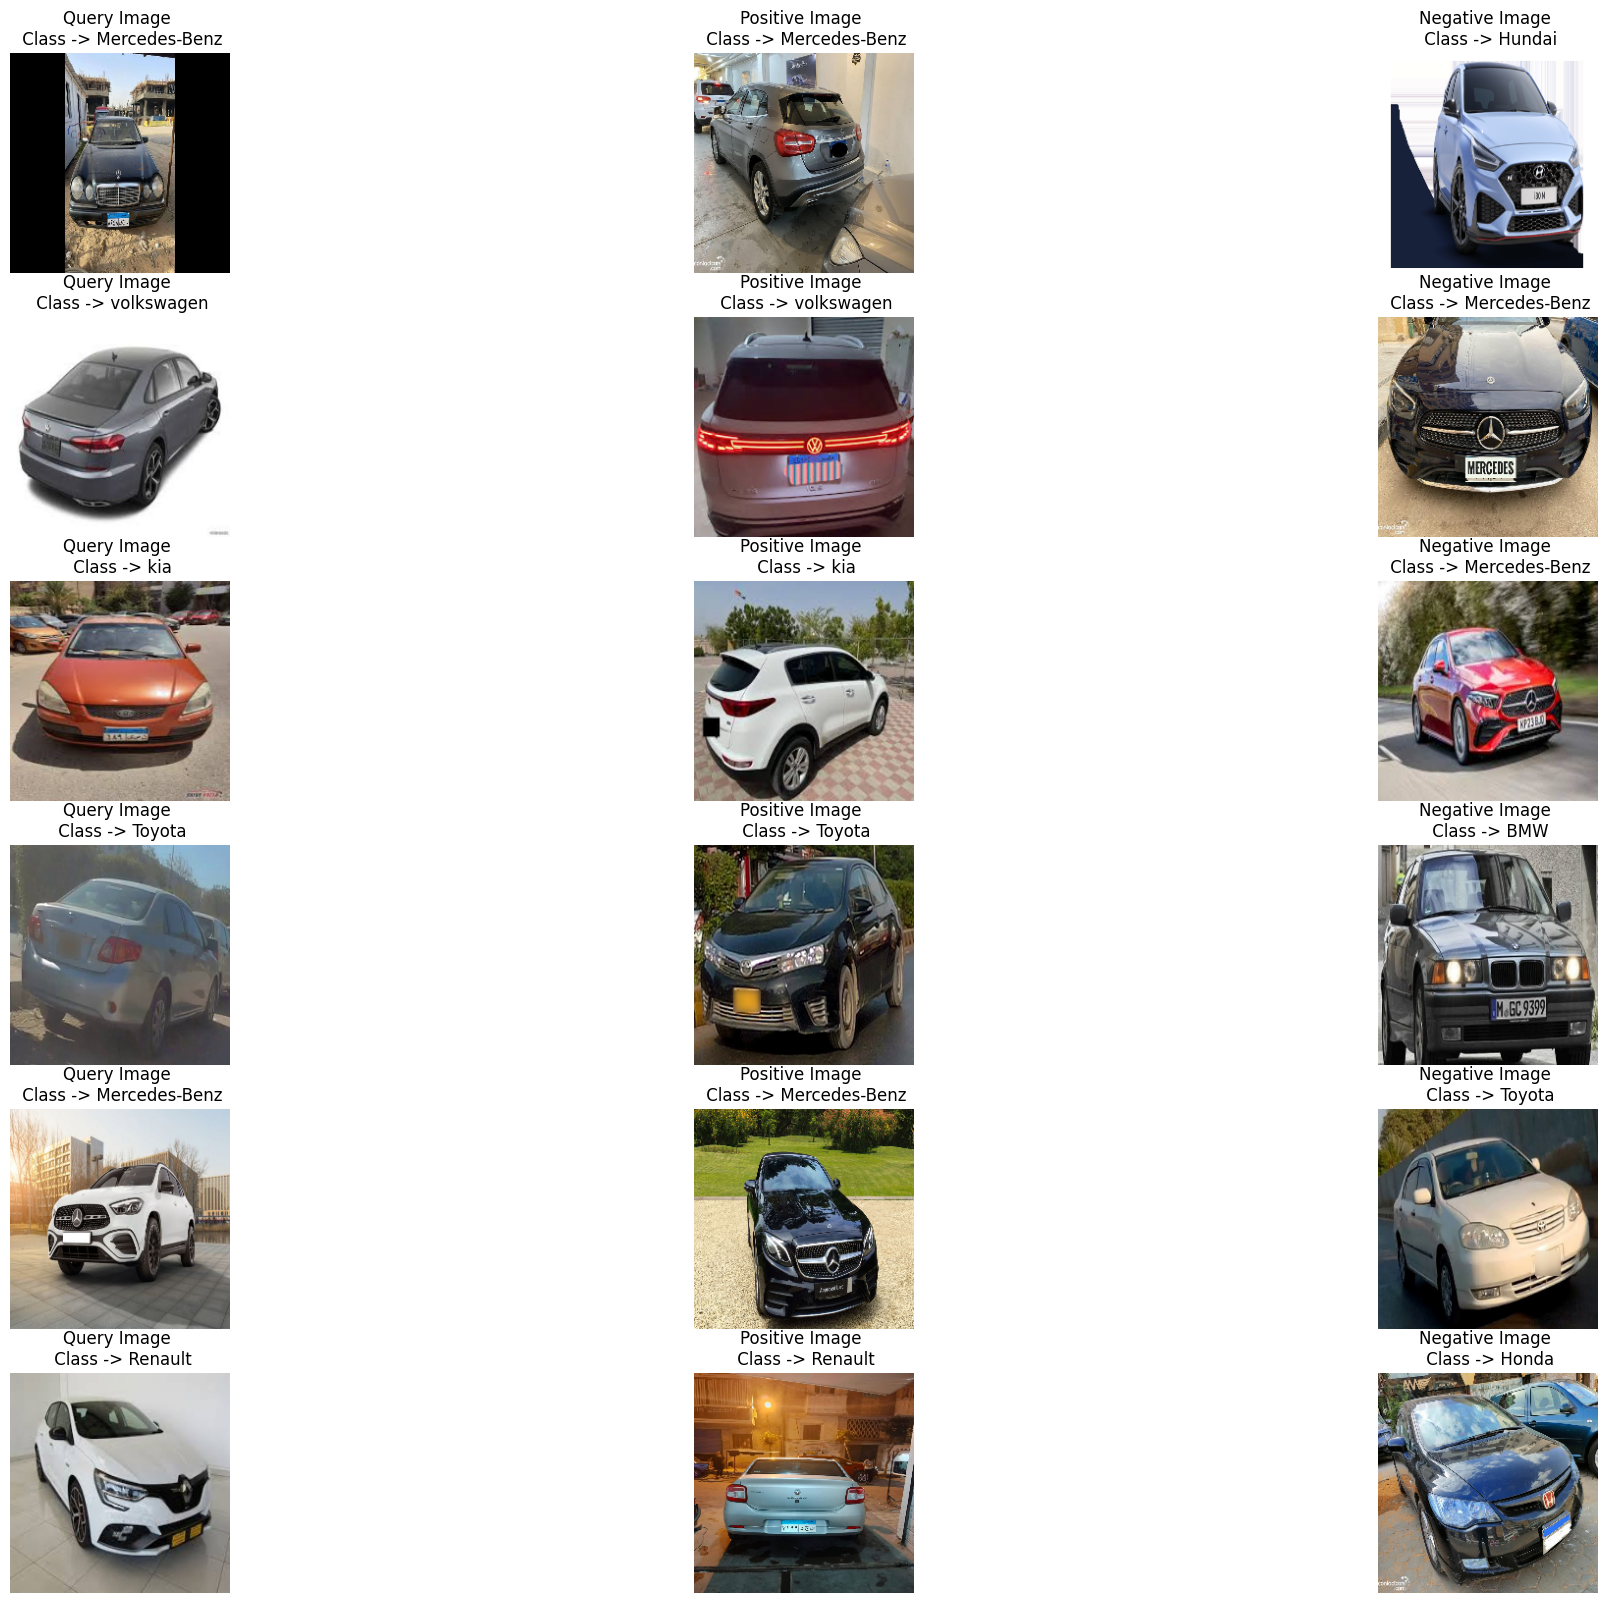

TEST Data Visualization is in process...



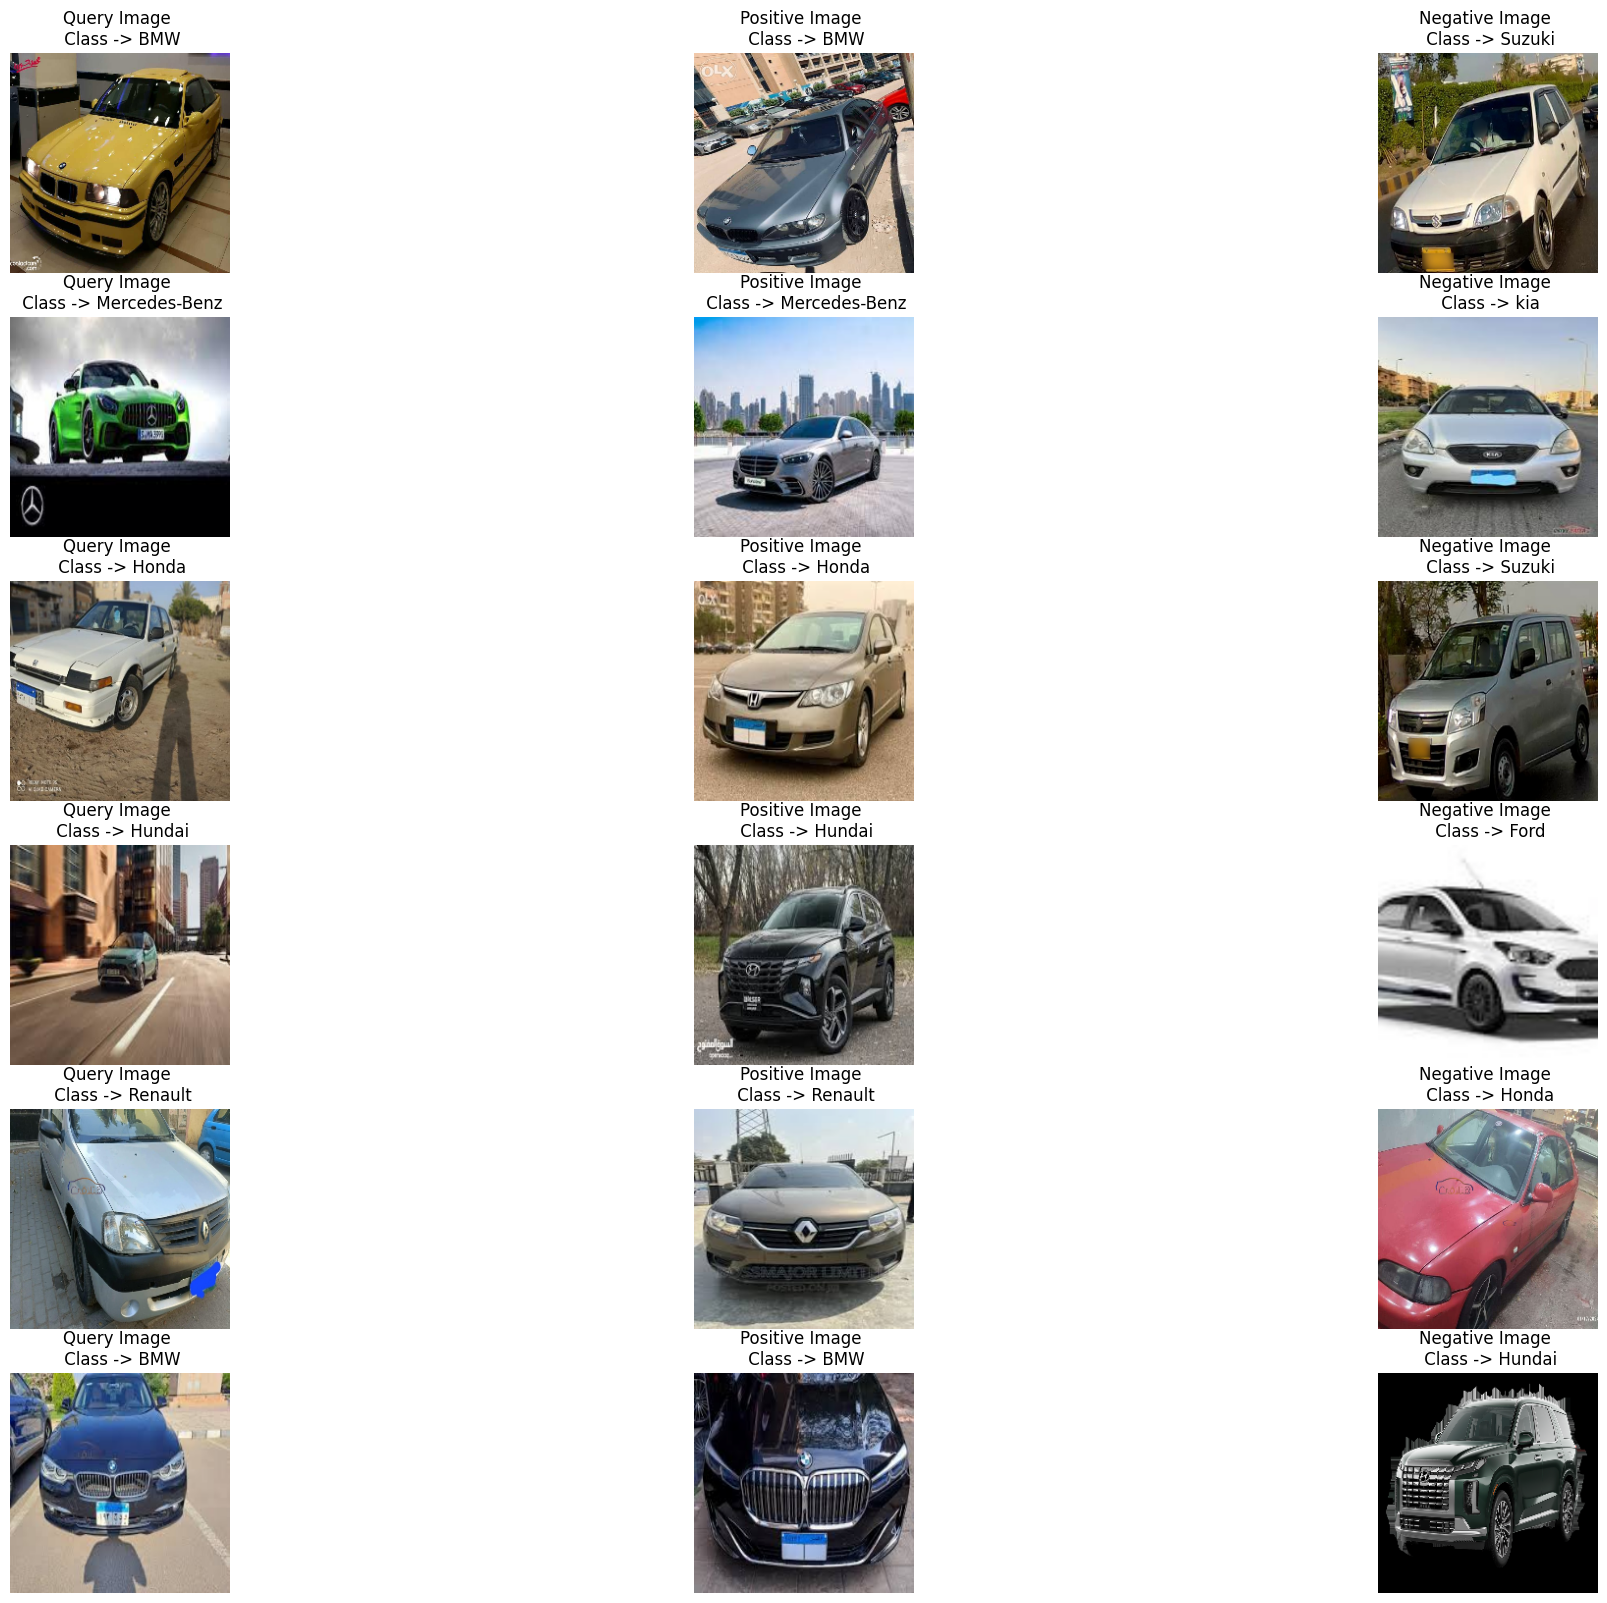

In [ ]:
vis.visualization()

<div style='background-color: #fff7f7; border: 2px solid '>
    <font size="+2" color="lightgreen" ><b>✨  AI Model Train and Validation ✨</b></font>
</div>

In [ ]:
! pip install torchmetrics

In [ ]:
import os, timm, torch, datetime
from torchmetrics.classification import MulticlassStatScores, MulticlassF1Score
from tqdm import tqdm
from time import time

class TrainValidation:

    def __init__(self, model_name, tr_dl, val_dl, classes, device, lr, save_dir,
                 run_name, data_name, epochs, project_name, bs, patience = 5, dev_mode = False):

        self.model_name, self.classes, self.device      = model_name, classes, device
        self.data_name, self.lr, self.save_dir, self.bs = data_name, lr, save_dir, bs
        self.tr_dl, self.val_dl, self.patience, self.dm = tr_dl, val_dl, patience, dev_mode
        self.run_name, self.epochs, self.project_name   = run_name, epochs, project_name
        self.run()

    def init_model(self): self.model = timm.create_model(self.model_name, pretrained = False, num_classes = len(self.classes))

    def init_lists(self): self.tr_losses, self.val_losses, self.tr_sens, self.val_senss, self.tr_specs, self.val_specs, self.tr_accs, self.val_accs, self.tr_f1s, self.val_f1s, self.tr_times, self.vl_times = [], [], [], [], [], [], [], [], [], [], [], []

    def train_setup(self):

        self.best_loss, self.threshold, self.not_improved = float(torch.inf), 0.01, 0
        self.stop_train, self.tr_len, self.val_len        = False, len(self.tr_dl), len(self.val_dl)
        self.cs_lbls = {"cos_pos": torch.tensor(1.).unsqueeze(0), "cos_neg": torch.tensor(-1.).unsqueeze(0)}
        self.ckpt_path = f"{self.save_dir}/{self.data_name}_{self.run_name}_{self.model_name}_best_model.pth"
        run_name = f"{self.run_name}_{self.model_name}_bs_{self.bs}"

        str_time = str(datetime.datetime.now()).split(".")[0]

        self.model.to(self.device).eval()
        self.ce_loss_fn   = torch.nn.CrossEntropyLoss()
        self.cs_loss_fn   = torch.nn.CosineEmbeddingLoss(margin = 0.3)
        self.optimizer   = torch.optim.Adam(params = self.model.parameters(), lr = self.lr)
        self.f1_score    = MulticlassF1Score(num_classes = len(self.classes), average = "micro").to(self.device)
        self.stat_scores = MulticlassStatScores(num_classes = len(self.classes), average = "micro").to(self.device)

    def makedirs(self, path): os.makedirs(path, exist_ok = True)

    def get_fms(self, fms):

        """
        s
        This function gets feature map with size (bs, fm_shape, 7, 7)
        applies average pooling and returns feature map with shape (bs, fm_shape).

        Parameter:

            fm - feature map, tensor.

        Output:

            fm - reshaped feature map, tensor.

        """

        pool = torch.nn.AvgPool2d((fms[0].shape[2], fms[0].shape[3]))

        return [torch.reshape(pool(fm), (-1, fm.shape[1])) for fm in fms]

    def get_logits(self, ims): return [self.model.forward_features(im) for im in ims]

    def get_preds(self, fts): return [self.model.forward_head(ft) for ft in fts]

    def get_cs_loss(self, qry_fms, pos_fms, neg_fms): return self.cs_loss_fn(qry_fms, pos_fms, self.cs_lbls["cos_pos"].to(self.device)) + self.cs_loss_fn(qry_fms, neg_fms, self.cs_lbls["cos_neg"].to(self.device))

    def get_ce_loss(self, qry_preds, pos_preds, qry_lbls): return self.ce_loss_fn(qry_preds, qry_lbls) + self.ce_loss_fn(pos_preds, qry_lbls)

    def get_preds_loss(self, qry_ims, pos_ims, neg_ims, qry_lbls):

        # Get logits
        qry_logits, pos_logits, neg_logits = self.get_logits([qry_ims, pos_ims, neg_ims])
        qry_preds, pos_preds = self.get_preds([qry_logits, pos_logits])

        # Contrastive loss
        qry_fms, pos_fms, neg_fms = self.get_fms([qry_logits, pos_logits, neg_logits])
        cs_loss = self.get_cs_loss(qry_fms, pos_fms, neg_fms)

        # Cross entropy loss
        ce_loss = self.get_ce_loss(qry_preds, pos_preds, qry_lbls)

        # Final loss
        loss = cs_loss + ce_loss

        return torch.argmax(qry_preds, dim = 1), loss

    def eval_train_batch(self, preds, gts, loss):

        self.epoch_acc    += (preds == gts).sum().item()
        self.epoch_loss   += loss.item()
        self.epoch_f1     += self.f1_score(preds, gts)
        tp, fp, tn, fn, _  = self.stat_scores(preds, gts)
        self.spec         += tn / (tn + fp)
        self.sens         += tp / (tp + fn)

    def eval_valid_batch(self, preds, gts, loss):

        self.val_epoch_loss   += loss.item()
        self.val_epoch_acc    += (preds == gts).sum().item()
        self.val_epoch_f1     +=  self.f1_score(preds, gts)
        tp, fp, tn, fn, _      = self.stat_scores(preds, gts)
        self.val_spec         += tn / (tn + fp)
        self.val_sens         += tp / (tp + fn)

    @staticmethod
    def to_device(batch, device): return batch["qry_im"].to(device), batch["pos_im"].to(device), batch["neg_im"].to(device), batch["qry_gt"].to(device)

    def train_one_epoch(self, epoch):

        self.model.train()
        self.epoch_loss, self.epoch_acc, self.epoch_f1, self.loss, self.sens, self.spec = 0, 0, 0, 0, 0, 0

        tr_start = time();
        for idx, batch in tqdm(enumerate(self.tr_dl)):

            if self.dm:
                if idx == 1: break

            qry_ims, pos_ims, neg_ims, qry_im_lbls = TrainValidation.to_device(batch, device = self.device)

            qry_preds, loss = self.get_preds_loss(qry_ims, pos_ims, neg_ims, qry_im_lbls)
            self.eval_train_batch(qry_preds, qry_im_lbls, loss)
            self.optimizer.zero_grad(); loss.backward(); self.optimizer.step()

        tr_time = time() - tr_start; self.tr_times.append(tr_time)
        tr_loss_to_track = self.epoch_loss / self.tr_len
        tr_sens_to_track = self.sens / self.tr_len
        tr_spec_to_track = self.spec / self.tr_len
        tr_acc_to_track  = self.epoch_acc  / len(self.tr_dl.dataset)
        tr_f1_to_track   = self.epoch_f1   / self.tr_len
        self.tr_losses.append(tr_loss_to_track); self.tr_accs.append(tr_acc_to_track); self.tr_f1s.append(tr_f1_to_track); self.tr_sens.append(tr_sens_to_track); self.tr_specs.append(tr_spec_to_track)

        print("\n~~~~~~~~~~~~~~~~~~~~ TRAIN PROCESS STATS ~~~~~~~~~~~~~~~~~~~~")
        print(f"\n{epoch + 1}-epoch train process is completed!\n")
        print(f"{epoch + 1}-epoch train loss          -> {tr_loss_to_track:.3f}")
        print(f"{epoch + 1}-epoch train spec          -> {tr_spec_to_track:.3f}")
        print(f"{epoch + 1}-epoch train sens          -> {tr_sens_to_track:.3f}")
        print(f"{epoch + 1}-epoch train accuracy      -> {tr_acc_to_track:.3f}")
        print(f"{epoch + 1}-epoch train f1-score      -> {tr_f1_to_track:.3f}")

    def eval_one_epoch(self, epoch):

        self.val_epoch_loss, self.val_epoch_acc, self.val_epoch_f1, self.val_sens, self.val_spec = 0, 0, 0, 0, 0
        self.model.eval()
        with torch.no_grad():
            vl_start = time()
            for idx, batch in enumerate(self.val_dl):

                if self.dm:
                    if idx == 1: break

                qry_ims, pos_ims, neg_ims, qry_im_lbls = TrainValidation.to_device(batch, device = self.device)

                qry_preds, loss = self.get_preds_loss(qry_ims, pos_ims, neg_ims, qry_im_lbls)
                self.eval_valid_batch(qry_preds, qry_im_lbls, loss)

            vl_time = time() - vl_start; self.vl_times.append(vl_time)
            val_loss_to_track = self.val_epoch_loss  / self.val_len
            val_sens_to_track = self.val_sens / self.val_len
            val_spec_to_track = self.val_spec / self.val_len
            val_acc_to_track  = self.val_epoch_acc   / len(self.val_dl.dataset)
            val_f1_to_track   = self.val_epoch_f1    / self.val_len
            self.val_losses.append(val_loss_to_track); self.val_accs.append(val_acc_to_track); self.val_f1s.append(val_f1_to_track); self.val_senss.append(val_sens_to_track); self.val_specs.append(val_spec_to_track)

            print(f"\n{epoch + 1}-epoch validation process is completed!\n")
            print(f"{epoch + 1}-epoch validation loss     -> {val_loss_to_track:.3f}")
            print(f"{epoch + 1}-epoch validation spec     -> {val_spec_to_track:.3f}")
            print(f"{epoch + 1}-epoch validation sens     -> {val_sens_to_track:.3f}")
            print(f"{epoch + 1}-epoch validation accuracy -> {val_acc_to_track:.3f}")
            print(f"{epoch + 1}-epoch validation f1-score -> {val_f1_to_track:.3f}")

            print("\n~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")

        return val_loss_to_track

    def save_best_model(self): torch.save(self.model.state_dict(), self.ckpt_path); print("Pretrained weights of the model with lowest loss are successfully saved!")

    def epoch_summary(self, metric):

        if (metric + self.threshold) < self.best_loss:

            print(f"\nValidation loss is decreased from {self.best_loss:.5f} to {metric:.5f}")
            print("Saving the best model with the lowest loss value...\n")
            self.best_loss = metric
            self.save_best_model()

        else:

            self.not_improved += 1
            print(f"\nValidation loss is not significantly decreased from {self.best_loss:.5f}. The current epoch loss is {metric:.5f}.")
            print(f"Validation loss value did not decrease for {self.not_improved} epochs")
            if self.not_improved == self.patience:
                print(f"Stop training since loss value did not decrease for {self.patience} epochs.")
                self.stop_train = True

        if metric < 0.1: print(f"Stop training since loss value is small enough..."); self.stop_train = True

    def train(self):

        print("Start training...")
        for epoch in range(self.epochs):
            if self.dm:
                if epoch == 1: break
            self.train_one_epoch(epoch); loss = self.eval_one_epoch(epoch)
            self.epoch_summary(loss)
            if self.stop_train: break

    def get_stats(self): return [self.tr_losses, self.val_losses, self.tr_accs, self.val_accs, self.tr_f1s, self.val_f1s, self.tr_specs, self.val_specs, self.tr_sens, self.val_senss, self.tr_times, self.vl_times]

    def run(self): self.makedirs(self.save_dir); self.init_lists(); self.init_model(); self.train_setup(); self.train()

project_name, run_name, model_name   = "kaggle", "triplet", "rexnet_150"
save_dir, data_name, epochs, device  = "saved_models", "cars", 50, "cuda"

results = TrainValidation(model_name = model_name, tr_dl = tr_dl, val_dl = vl_dl,
                          classes = classes, device = device, lr = 3e-4, save_dir = save_dir,
                          data_name = data_name, project_name = project_name, bs = bs, run_name = run_name,
                          epochs = epochs, patience = 5, dev_mode = False).get_stats()

Start training...


568it [02:49,  3.36it/s]


~~~~~~~~~~~~~~~~~~~~ TRAIN PROCESS STATS ~~~~~~~~~~~~~~~~~~~~

1-epoch train process is completed!

1-epoch train loss          -> 5.577
1-epoch train spec          -> 0.949
1-epoch train sens          -> 0.232
1-epoch train accuracy      -> 0.232
1-epoch train f1-score      -> 0.232



1-epoch validation process is completed!

1-epoch validation loss     -> 4.489
1-epoch validation spec     -> 0.959
1-epoch validation sens     -> 0.381
1-epoch validation accuracy -> 0.381
1-epoch validation f1-score -> 0.381

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Validation loss is decreased from inf to 4.48882
Saving the best model with the lowest loss value...

Pretrained weights of the model with lowest loss are successfully saved!


568it [02:50,  3.33it/s]


~~~~~~~~~~~~~~~~~~~~ TRAIN PROCESS STATS ~~~~~~~~~~~~~~~~~~~~

2-epoch train process is completed!

2-epoch train loss          -> 4.135
2-epoch train spec          -> 0.961
2-epoch train sens          -> 0.408
2-epoch train accuracy      -> 0.408
2-epoch train f1-score      -> 0.408



2-epoch validation process is completed!

2-epoch validation loss     -> 3.489
2-epoch validation spec     -> 0.966
2-epoch validation sens     -> 0.495
2-epoch validation accuracy -> 0.498
2-epoch validation f1-score -> 0.495

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Validation loss is decreased from 4.48882 to 3.48949
Saving the best model with the lowest loss value...

Pretrained weights of the model with lowest loss are successfully saved!


568it [02:42,  3.49it/s]


~~~~~~~~~~~~~~~~~~~~ TRAIN PROCESS STATS ~~~~~~~~~~~~~~~~~~~~

3-epoch train process is completed!

3-epoch train loss          -> 2.882
3-epoch train spec          -> 0.974
3-epoch train sens          -> 0.604
3-epoch train accuracy      -> 0.605
3-epoch train f1-score      -> 0.604



3-epoch validation process is completed!

3-epoch validation loss     -> 2.343
3-epoch validation spec     -> 0.976
3-epoch validation sens     -> 0.641
3-epoch validation accuracy -> 0.640
3-epoch validation f1-score -> 0.641

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Validation loss is decreased from 3.48949 to 2.34267
Saving the best model with the lowest loss value...

Pretrained weights of the model with lowest loss are successfully saved!


568it [02:49,  3.35it/s]


~~~~~~~~~~~~~~~~~~~~ TRAIN PROCESS STATS ~~~~~~~~~~~~~~~~~~~~

4-epoch train process is completed!

4-epoch train loss          -> 1.965
4-epoch train spec          -> 0.983
4-epoch train sens          -> 0.748
4-epoch train accuracy      -> 0.748
4-epoch train f1-score      -> 0.748



4-epoch validation process is completed!

4-epoch validation loss     -> 1.980
4-epoch validation spec     -> 0.981
4-epoch validation sens     -> 0.714
4-epoch validation accuracy -> 0.714
4-epoch validation f1-score -> 0.714

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Validation loss is decreased from 2.34267 to 1.97969
Saving the best model with the lowest loss value...

Pretrained weights of the model with lowest loss are successfully saved!


568it [02:49,  3.36it/s]


~~~~~~~~~~~~~~~~~~~~ TRAIN PROCESS STATS ~~~~~~~~~~~~~~~~~~~~

5-epoch train process is completed!

5-epoch train loss          -> 1.446
5-epoch train spec          -> 0.989
5-epoch train sens          -> 0.831
5-epoch train accuracy      -> 0.832
5-epoch train f1-score      -> 0.831



5-epoch validation process is completed!

5-epoch validation loss     -> 1.444
5-epoch validation spec     -> 0.986
5-epoch validation sens     -> 0.789
5-epoch validation accuracy -> 0.786
5-epoch validation f1-score -> 0.789

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Validation loss is decreased from 1.97969 to 1.44416
Saving the best model with the lowest loss value...

Pretrained weights of the model with lowest loss are successfully saved!


568it [02:40,  3.53it/s]


~~~~~~~~~~~~~~~~~~~~ TRAIN PROCESS STATS ~~~~~~~~~~~~~~~~~~~~

6-epoch train process is completed!

6-epoch train loss          -> 1.222
6-epoch train spec          -> 0.991
6-epoch train sens          -> 0.867
6-epoch train accuracy      -> 0.867
6-epoch train f1-score      -> 0.867



6-epoch validation process is completed!

6-epoch validation loss     -> 1.289
6-epoch validation spec     -> 0.988
6-epoch validation sens     -> 0.822
6-epoch validation accuracy -> 0.819
6-epoch validation f1-score -> 0.822

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Validation loss is decreased from 1.44416 to 1.28870
Saving the best model with the lowest loss value...

Pretrained weights of the model with lowest loss are successfully saved!


568it [02:48,  3.37it/s]


~~~~~~~~~~~~~~~~~~~~ TRAIN PROCESS STATS ~~~~~~~~~~~~~~~~~~~~

7-epoch train process is completed!

7-epoch train loss          -> 1.067
7-epoch train spec          -> 0.993
7-epoch train sens          -> 0.893
7-epoch train accuracy      -> 0.893
7-epoch train f1-score      -> 0.893



7-epoch validation process is completed!

7-epoch validation loss     -> 1.088
7-epoch validation spec     -> 0.991
7-epoch validation sens     -> 0.864
7-epoch validation accuracy -> 0.862
7-epoch validation f1-score -> 0.864

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Validation loss is decreased from 1.28870 to 1.08809
Saving the best model with the lowest loss value...

Pretrained weights of the model with lowest loss are successfully saved!


568it [02:43,  3.47it/s]


~~~~~~~~~~~~~~~~~~~~ TRAIN PROCESS STATS ~~~~~~~~~~~~~~~~~~~~

8-epoch train process is completed!

8-epoch train loss          -> 0.928
8-epoch train spec          -> 0.994
8-epoch train sens          -> 0.912
8-epoch train accuracy      -> 0.912
8-epoch train f1-score      -> 0.912



8-epoch validation process is completed!

8-epoch validation loss     -> 0.955
8-epoch validation spec     -> 0.991
8-epoch validation sens     -> 0.870
8-epoch validation accuracy -> 0.870
8-epoch validation f1-score -> 0.870

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Validation loss is decreased from 1.08809 to 0.95548
Saving the best model with the lowest loss value...

Pretrained weights of the model with lowest loss are successfully saved!


568it [02:46,  3.42it/s]


~~~~~~~~~~~~~~~~~~~~ TRAIN PROCESS STATS ~~~~~~~~~~~~~~~~~~~~

9-epoch train process is completed!

9-epoch train loss          -> 0.847
9-epoch train spec          -> 0.995
9-epoch train sens          -> 0.921
9-epoch train accuracy      -> 0.921
9-epoch train f1-score      -> 0.921



9-epoch validation process is completed!

9-epoch validation loss     -> 1.086
9-epoch validation spec     -> 0.991
9-epoch validation sens     -> 0.866
9-epoch validation accuracy -> 0.867
9-epoch validation f1-score -> 0.866

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Validation loss is not significantly decreased from 0.95548. The current epoch loss is 1.08559.
Validation loss value did not decrease for 1 epochs


568it [02:48,  3.37it/s]


~~~~~~~~~~~~~~~~~~~~ TRAIN PROCESS STATS ~~~~~~~~~~~~~~~~~~~~

10-epoch train process is completed!

10-epoch train loss          -> 0.809
10-epoch train spec          -> 0.995
10-epoch train sens          -> 0.923
10-epoch train accuracy      -> 0.923
10-epoch train f1-score      -> 0.923



10-epoch validation process is completed!

10-epoch validation loss     -> 0.771
10-epoch validation spec     -> 0.994
10-epoch validation sens     -> 0.912
10-epoch validation accuracy -> 0.913
10-epoch validation f1-score -> 0.912

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Validation loss is decreased from 0.95548 to 0.77139
Saving the best model with the lowest loss value...

Pretrained weights of the model with lowest loss are successfully saved!


568it [02:52,  3.29it/s]


~~~~~~~~~~~~~~~~~~~~ TRAIN PROCESS STATS ~~~~~~~~~~~~~~~~~~~~

11-epoch train process is completed!

11-epoch train loss          -> 0.702
11-epoch train spec          -> 0.996
11-epoch train sens          -> 0.942
11-epoch train accuracy      -> 0.942
11-epoch train f1-score      -> 0.942



11-epoch validation process is completed!

11-epoch validation loss     -> 0.722
11-epoch validation spec     -> 0.994
11-epoch validation sens     -> 0.917
11-epoch validation accuracy -> 0.917
11-epoch validation f1-score -> 0.917

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Validation loss is decreased from 0.77139 to 0.72164
Saving the best model with the lowest loss value...

Pretrained weights of the model with lowest loss are successfully saved!


568it [02:50,  3.32it/s]


~~~~~~~~~~~~~~~~~~~~ TRAIN PROCESS STATS ~~~~~~~~~~~~~~~~~~~~

12-epoch train process is completed!

12-epoch train loss          -> 0.664
12-epoch train spec          -> 0.996
12-epoch train sens          -> 0.943
12-epoch train accuracy      -> 0.943
12-epoch train f1-score      -> 0.943



12-epoch validation process is completed!

12-epoch validation loss     -> 0.631
12-epoch validation spec     -> 0.997
12-epoch validation sens     -> 0.950
12-epoch validation accuracy -> 0.949
12-epoch validation f1-score -> 0.950

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Validation loss is decreased from 0.72164 to 0.63062
Saving the best model with the lowest loss value...

Pretrained weights of the model with lowest loss are successfully saved!


568it [02:45,  3.43it/s]


~~~~~~~~~~~~~~~~~~~~ TRAIN PROCESS STATS ~~~~~~~~~~~~~~~~~~~~

13-epoch train process is completed!

13-epoch train loss          -> 0.595
13-epoch train spec          -> 0.997
13-epoch train sens          -> 0.952
13-epoch train accuracy      -> 0.952
13-epoch train f1-score      -> 0.952



13-epoch validation process is completed!

13-epoch validation loss     -> 0.603
13-epoch validation spec     -> 0.996
13-epoch validation sens     -> 0.939
13-epoch validation accuracy -> 0.938
13-epoch validation f1-score -> 0.939

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Validation loss is decreased from 0.63062 to 0.60340
Saving the best model with the lowest loss value...

Pretrained weights of the model with lowest loss are successfully saved!


568it [02:45,  3.43it/s]


~~~~~~~~~~~~~~~~~~~~ TRAIN PROCESS STATS ~~~~~~~~~~~~~~~~~~~~

14-epoch train process is completed!

14-epoch train loss          -> 0.608
14-epoch train spec          -> 0.996
14-epoch train sens          -> 0.946
14-epoch train accuracy      -> 0.946
14-epoch train f1-score      -> 0.946



14-epoch validation process is completed!

14-epoch validation loss     -> 0.599
14-epoch validation spec     -> 0.996
14-epoch validation sens     -> 0.936
14-epoch validation accuracy -> 0.935
14-epoch validation f1-score -> 0.936

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Validation loss is not significantly decreased from 0.60340. The current epoch loss is 0.59857.
Validation loss value did not decrease for 2 epochs


568it [02:41,  3.52it/s]



~~~~~~~~~~~~~~~~~~~~ TRAIN PROCESS STATS ~~~~~~~~~~~~~~~~~~~~

15-epoch train process is completed!

15-epoch train loss          -> 0.514
15-epoch train spec          -> 0.997
15-epoch train sens          -> 0.962
15-epoch train accuracy      -> 0.962
15-epoch train f1-score      -> 0.962

15-epoch validation process is completed!

15-epoch validation loss     -> 0.511
15-epoch validation spec     -> 0.997
15-epoch validation sens     -> 0.952
15-epoch validation accuracy -> 0.952
15-epoch validation f1-score -> 0.952

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Validation loss is decreased from 0.60340 to 0.51085
Saving the best model with the lowest loss value...

Pretrained weights of the model with lowest loss are successfully saved!


568it [02:43,  3.47it/s]


~~~~~~~~~~~~~~~~~~~~ TRAIN PROCESS STATS ~~~~~~~~~~~~~~~~~~~~

16-epoch train process is completed!

16-epoch train loss          -> 0.573
16-epoch train spec          -> 0.997
16-epoch train sens          -> 0.952
16-epoch train accuracy      -> 0.952
16-epoch train f1-score      -> 0.952



16-epoch validation process is completed!

16-epoch validation loss     -> 0.507
16-epoch validation spec     -> 0.996
16-epoch validation sens     -> 0.945
16-epoch validation accuracy -> 0.946
16-epoch validation f1-score -> 0.945

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Validation loss is not significantly decreased from 0.51085. The current epoch loss is 0.50738.
Validation loss value did not decrease for 3 epochs


568it [02:42,  3.49it/s]



~~~~~~~~~~~~~~~~~~~~ TRAIN PROCESS STATS ~~~~~~~~~~~~~~~~~~~~

17-epoch train process is completed!

17-epoch train loss          -> 0.543
17-epoch train spec          -> 0.997
17-epoch train sens          -> 0.954
17-epoch train accuracy      -> 0.955
17-epoch train f1-score      -> 0.954

17-epoch validation process is completed!

17-epoch validation loss     -> 0.399
17-epoch validation spec     -> 0.998
17-epoch validation sens     -> 0.964
17-epoch validation accuracy -> 0.963
17-epoch validation f1-score -> 0.964

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Validation loss is decreased from 0.51085 to 0.39895
Saving the best model with the lowest loss value...

Pretrained weights of the model with lowest loss are successfully saved!


568it [02:42,  3.49it/s]



~~~~~~~~~~~~~~~~~~~~ TRAIN PROCESS STATS ~~~~~~~~~~~~~~~~~~~~

18-epoch train process is completed!

18-epoch train loss          -> 0.474
18-epoch train spec          -> 0.997
18-epoch train sens          -> 0.962
18-epoch train accuracy      -> 0.962
18-epoch train f1-score      -> 0.962

18-epoch validation process is completed!

18-epoch validation loss     -> 0.385
18-epoch validation spec     -> 0.997
18-epoch validation sens     -> 0.958
18-epoch validation accuracy -> 0.957
18-epoch validation f1-score -> 0.958

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Validation loss is decreased from 0.39895 to 0.38504
Saving the best model with the lowest loss value...

Pretrained weights of the model with lowest loss are successfully saved!


568it [02:47,  3.40it/s]


~~~~~~~~~~~~~~~~~~~~ TRAIN PROCESS STATS ~~~~~~~~~~~~~~~~~~~~

19-epoch train process is completed!

19-epoch train loss          -> 0.415
19-epoch train spec          -> 0.998
19-epoch train sens          -> 0.968
19-epoch train accuracy      -> 0.968
19-epoch train f1-score      -> 0.968



19-epoch validation process is completed!

19-epoch validation loss     -> 0.357
19-epoch validation spec     -> 0.998
19-epoch validation sens     -> 0.967
19-epoch validation accuracy -> 0.967
19-epoch validation f1-score -> 0.967

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Validation loss is decreased from 0.38504 to 0.35665
Saving the best model with the lowest loss value...

Pretrained weights of the model with lowest loss are successfully saved!


568it [02:47,  3.39it/s]


~~~~~~~~~~~~~~~~~~~~ TRAIN PROCESS STATS ~~~~~~~~~~~~~~~~~~~~

20-epoch train process is completed!

20-epoch train loss          -> 0.396
20-epoch train spec          -> 0.998
20-epoch train sens          -> 0.972
20-epoch train accuracy      -> 0.972
20-epoch train f1-score      -> 0.972



20-epoch validation process is completed!

20-epoch validation loss     -> 0.411
20-epoch validation spec     -> 0.997
20-epoch validation sens     -> 0.956
20-epoch validation accuracy -> 0.956
20-epoch validation f1-score -> 0.956

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Validation loss is not significantly decreased from 0.35665. The current epoch loss is 0.41083.
Validation loss value did not decrease for 4 epochs


568it [02:48,  3.37it/s]



~~~~~~~~~~~~~~~~~~~~ TRAIN PROCESS STATS ~~~~~~~~~~~~~~~~~~~~

21-epoch train process is completed!

21-epoch train loss          -> 0.415
21-epoch train spec          -> 0.998
21-epoch train sens          -> 0.968
21-epoch train accuracy      -> 0.968
21-epoch train f1-score      -> 0.968

21-epoch validation process is completed!

21-epoch validation loss     -> 0.446
21-epoch validation spec     -> 0.997
21-epoch validation sens     -> 0.955
21-epoch validation accuracy -> 0.954
21-epoch validation f1-score -> 0.955

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Validation loss is not significantly decreased from 0.35665. The current epoch loss is 0.44612.
Validation loss value did not decrease for 5 epochs
Stop training since loss value did not decrease for 5 epochs.


<div style='background-color: #fff7f7; border: 2px solid '>
    <font size="+2" color="lightgreen" ><b>📈  Learning Curves 📉</b></font>
</div>

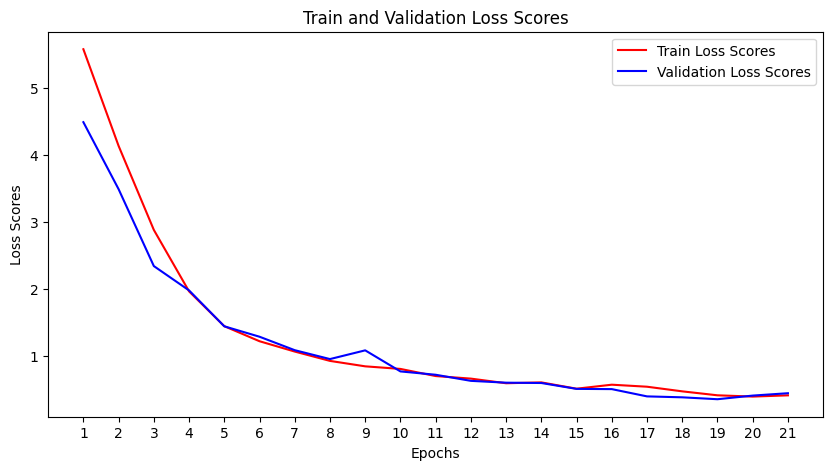

<Figure size 640x480 with 0 Axes>

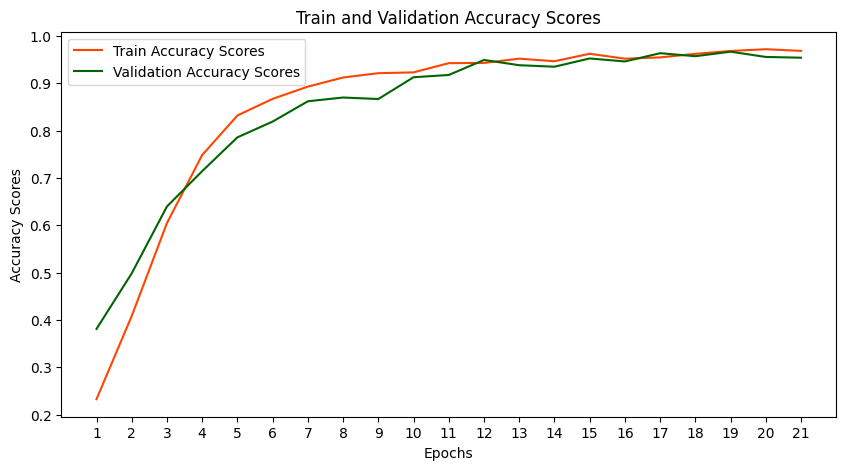

<Figure size 640x480 with 0 Axes>

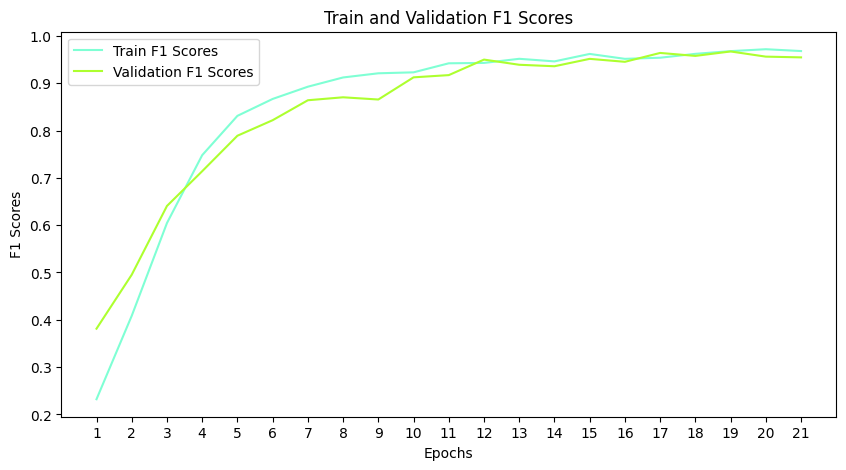

<Figure size 640x480 with 0 Axes>

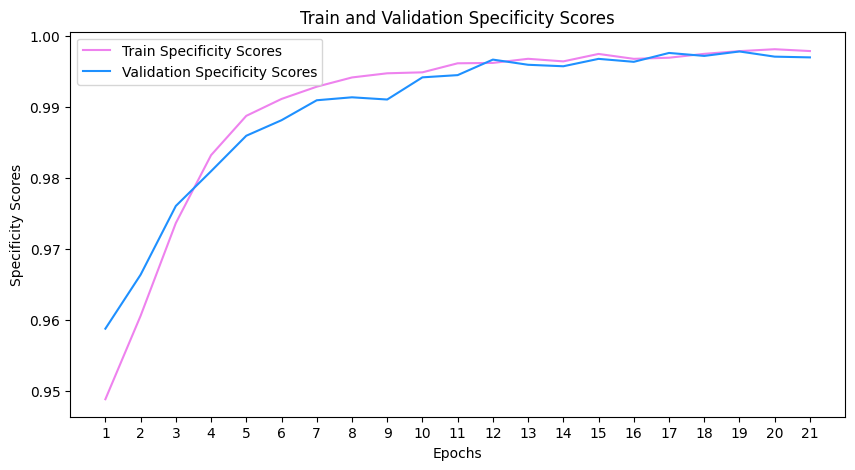

<Figure size 640x480 with 0 Axes>

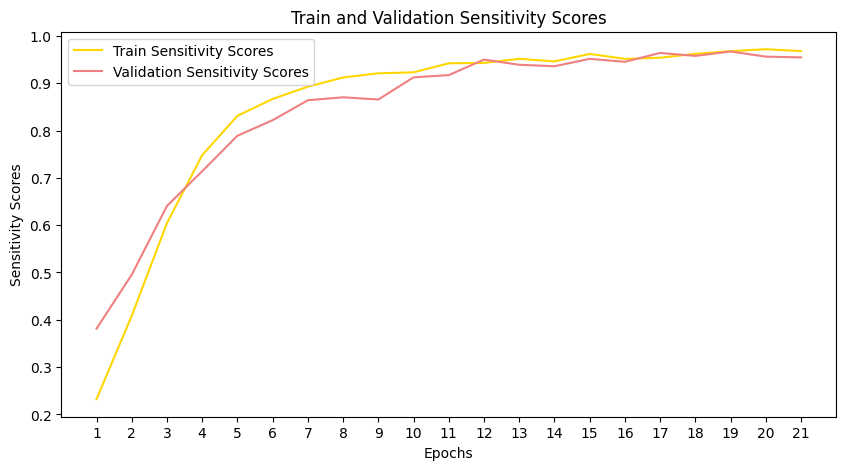

<Figure size 640x480 with 0 Axes>

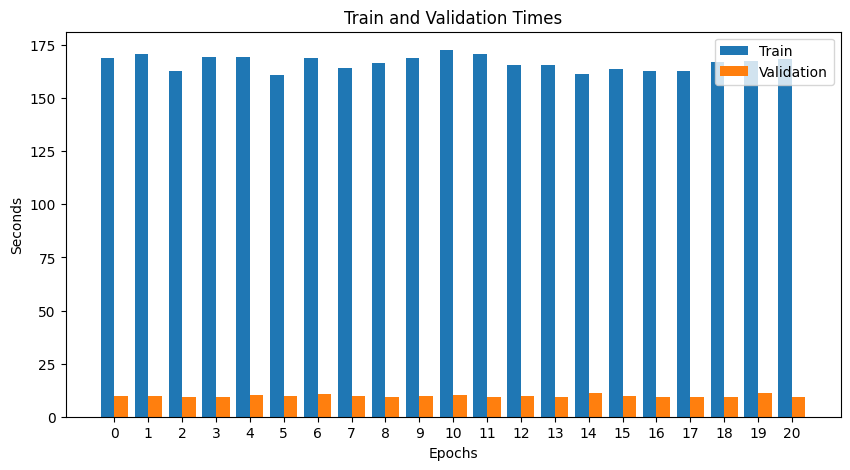

Learning curves can be found in stats

Train times can be found in stats directory under the name times.png



<Figure size 640x480 with 0 Axes>

In [ ]:
class TrainProcessSummary:
  def __init__(self, tr_losses, val_losses, tr_accs, val_accs, tr_f1s, val_f1s, tr_specs, val_specs,
               tr_sens, val_sens, tr_times, val_times, data_name, save_path = "stats"):

    self.makedirs(save_path)
    self.xlbl = "Epochs"
    self.times_sv_name = "times.png"
    self.data_name = data_name
    self.save_path = save_path
    self.tr_losses = tr_losses
    self.val_losses = val_losses
    self.tr_accs = tr_accs
    self.val_accs = val_accs
    self.tr_f1s = tr_f1s
    self.val_f1s = val_f1s
    self.tr_specs = tr_specs
    self.val_specs = val_specs
    self.tr_sens = tr_sens
    self.val_sens = val_sens
    self.tr_times = tr_times
    self.val_times = val_times
    self.get_ticks_labels()
    self.learning_curves()
    self.bar_plot()

    print(f"Learning curves can be found in {self.save_path}\n")
    print(f"Train times can be found in {self.save_path} directory under the name {self.times_sv_name}\n")


  def get_ticks_labels(self):
    self.xticks, self.xlabels = np.arange(len(self.tr_losses)), [i for i in range(1, len(self.tr_losses) + 1)]

  def makedirs(self, path): os.makedirs(path, exist_ok=True)

  def create_figure(self): plt.figure(figsize = (10, 5))

  def move2cpu(self, data): return [d.cpu() for d in data]

  def plot(self, data1, data2, plot_name, c1, c2):

    self.create_figure()
    need2beremoved = ["Sensitivity", "Specificity", "F1"]
    if plot_name in need2beremoved:
      data1 = self.move2cpu(data1)
      data2 = self.move2cpu(data2)
    label = f"{plot_name} Scores"
    plt.plot(data1, label = f"Train {label}", color = c1)
    plt.plot(data2, label = f"Validation {label}", color = c2)
    plt.xlabel(self.xlbl)
    plt.ylabel(label)
    plt.title(f"Train and Validation {label}")
    plt.xticks(ticks = self.xticks, labels = self.xlabels)
    plt.legend()
    plt.show()



  def save(self, save_name):

        sv_name = f"{self.data_name}_{save_name}"
        plt.savefig(f"{self.save_path}/{sv_name}")

  def learning_curves(self):

    self.plot(self.tr_losses, self.val_losses, "Loss", "red", "blue");                               self.save("losses.png")
    self.plot(self.tr_accs, self.val_accs, "Accuracy", "orangered", "darkgreen");                    self.save("accs.png")
    self.plot(self.tr_f1s, self.val_f1s, "F1", "aquamarine", "greenyellow");                         self.save("f1s.png")
    self.plot(self.tr_specs, self.val_specs, "Specificity", "violet", "dodgerblue");                self.save("specs.png")
    self.plot(self.tr_sens, self.val_sens, "Sensitivity", "gold", "lightcoral");                     self.save("sens.png")


  def bar_plot(self):

    self.create_figure()

    plt.bar(self.xticks - 0.2, self.tr_times, 0.4, label = "Train")
    plt.bar(self.xticks + 0.2, self.val_times, 0.4, label = "Validation")


    plt.xticks(self.xticks)
    plt.xlabel(self.xlbl)

    plt.ylabel("Seconds")
    plt.title("Train and Validation Times")

    plt.legend()
    plt.show()
    self.save(self.times_sv_name)

TrainProcessSummary(*results, data_name=data_name)

<div style='background-color: #fff7f7; border: 2px solid '>
    <font size="+2" color="magenta" ><b>✅  Inference and AI Model Performance Analysis with GradCAM ✅</b></font>
</div>

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 46.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for grad-cam: filename=grad_cam-1.4.6-py3-none-any.whl size=38340 sha256=5f30589bd41f46831e99f9d76491e01b364cdbad3da1b2774c7c7cde4c1ae6b2
  Stored in directory: /root/.cache/pip/wheels/5d/90/92/0661d038b2e6ce71cad21432f92c50b1d79887bd5eb82ff3b1
Successfully built grad-cam


Inference: 631it [00:17, 36.99it/s]


Accuracy of the model on the test data -> 0.957


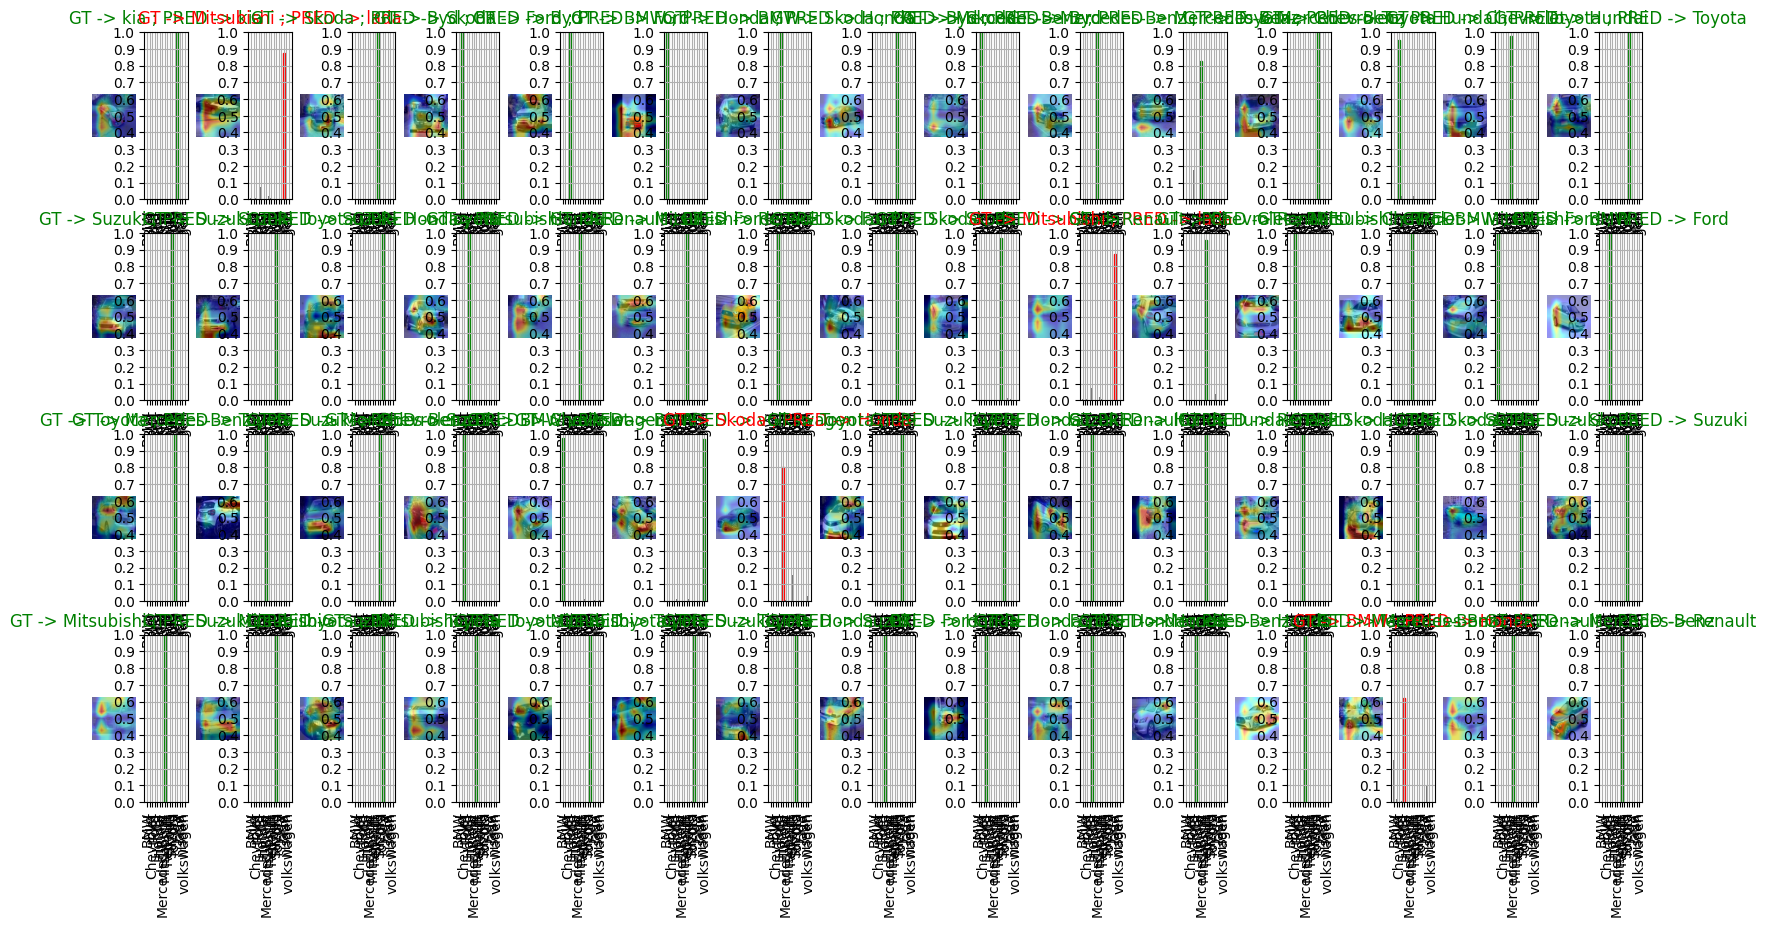

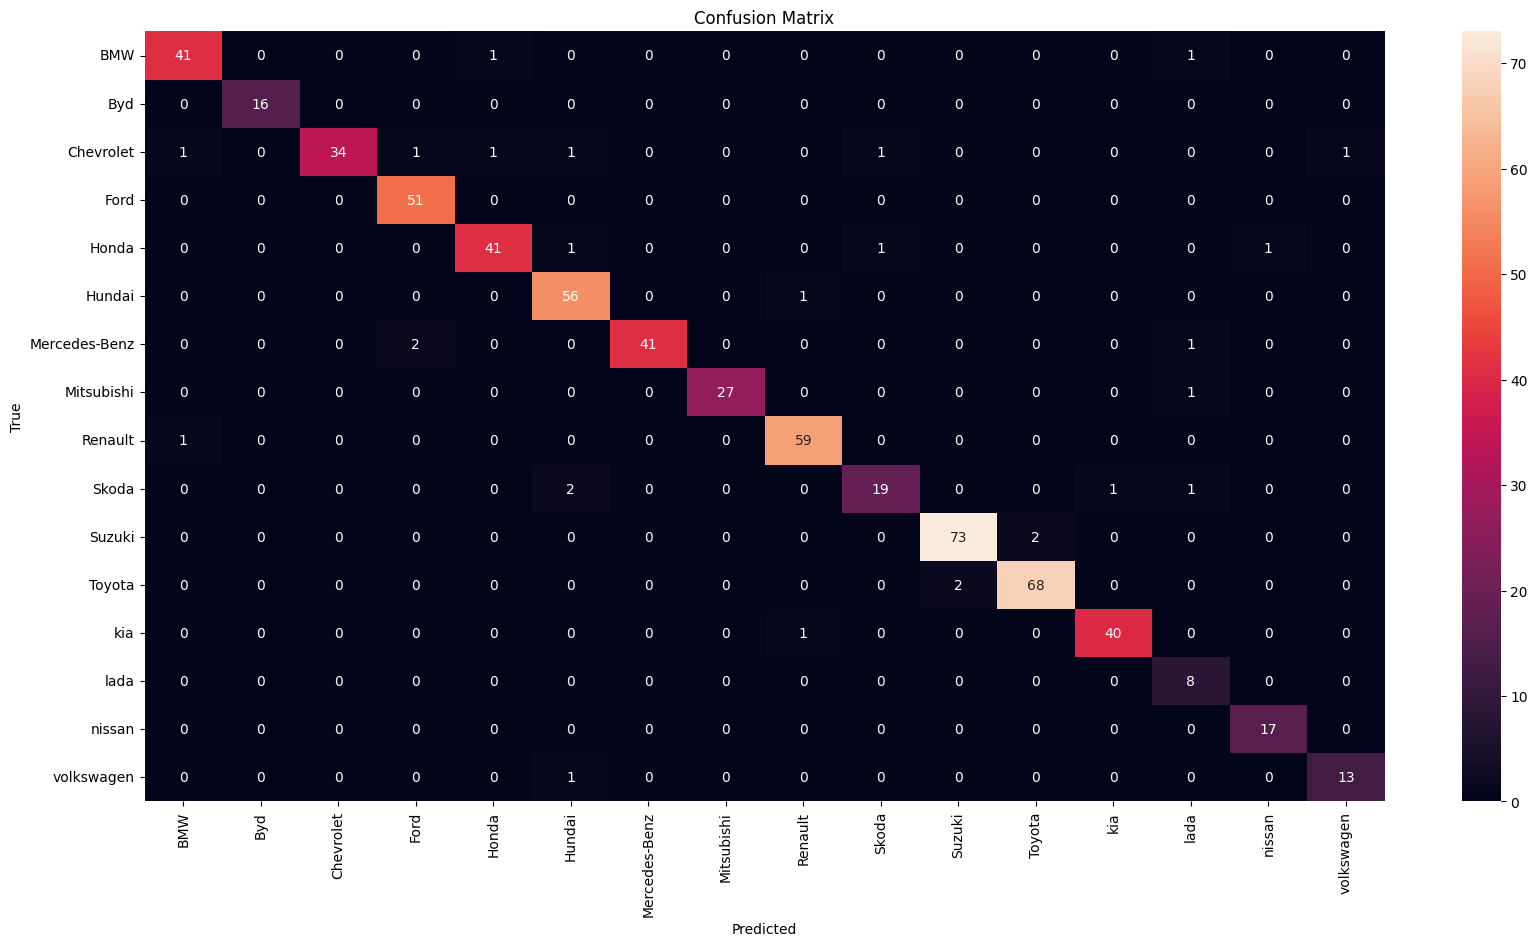

In [ ]:
!pip install grad-cam==1.4.6
import cv2
import seaborn as sns
from pytorch_grad_cam import GradCAM, GradCAMPlusPlus
from pytorch_grad_cam.utils.image import show_cam_on_image
from sklearn.metrics import confusion_matrix
from tqdm import tqdm

class Denormalize:
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        """
        Reverse the normalization applied to the image tensor.
        """
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
        return tensor

class ModelInferenceVisualizer:
    def __init__(self, model, device, class_names=None, im_size=224, mean = mean, std = std):

        self.denormalize = Denormalize(mean, std)
        self.model = model
        self.device = device
        self.class_names = class_names
        self.im_size = im_size
        self.model.eval()  # Set model to evaluation mode

    def tensor_to_image(self, tensor):
        """
        Convert a normalized tensor to a denormalized image array.
        """
        tensor = self.denormalize(tensor)  # Denormalize the tensor
        tensor = tensor.permute(1, 2, 0)  # Convert from CxHxW to HxWxC
        return (tensor.cpu().numpy() * 255).astype(np.uint8)

    def plot_value_array(self, logits, gt, class_names):
        """Plot the prediction probability array."""
        probs = torch.nn.functional.softmax(logits, dim=1)
        pred_class = torch.argmax(probs, dim=1)

        plt.grid(visible=True)
        plt.xticks(range(len(class_names)), class_names, rotation='vertical')
        plt.yticks(np.arange(0.0, 1.1, 0.1))
        bars = plt.bar(range(len(class_names)), [p.item() for p in probs[0]], color="#777777")
        plt.ylim([0, 1])
        if pred_class.item() == gt:
            bars[pred_class].set_color('green')
        else:
            bars[pred_class].set_color('red')

    def generate_cam_visualization(self, image_tensor):
        """Generate GradCAM visualization."""
        cam = GradCAMPlusPlus(model=self.model, target_layers=[self.model.features[-1]], use_cuda=self.device == "cuda")
        grayscale_cam = cam(input_tensor=image_tensor.unsqueeze(0))[0, :]
        return grayscale_cam

    def infer_and_visualize(self, test_dl, num_images=5, rows=2):
        """Perform inference and visualize predictions along with GradCAM."""
        preds, images, lbls, logitss = [], [], [], []
        accuracy, count = 0, 1

        with torch.no_grad():
            for idx, batch in tqdm(enumerate(test_dl), desc="Inference"):
                im, _, _, gt = TrainValidation.to_device(batch, device = self.device)
                logits = self.model(im)
                pred_class = torch.argmax(logits, dim=1)
                accuracy += (pred_class == gt).sum().item()
                images.append(im[0])
                logitss.append(logits[0])
                preds.append(pred_class[0].item())
                lbls.append(gt[0].item())

        print(f"Accuracy of the model on the test data -> {(accuracy / len(test_dl.dataset)):.3f}")

        plt.figure(figsize=(20, 10))
        indices = [random.randint(0, len(images) - 1) for _ in range(num_images)]
        for idx, index in enumerate(indices):
            # Convert and denormalize image
            im = self.tensor_to_image(images[index].squeeze())
            pred_idx = preds[index]
            gt_idx = lbls[index]

            # Display image
            plt.subplot(rows, 2 * num_images // rows, count)
            count += 1
            plt.imshow(im, cmap="gray")
            plt.axis("off")

            # GradCAM visualization
            grayscale_cam = self.generate_cam_visualization(images[index])
            visualization = show_cam_on_image(im / 255, grayscale_cam, image_weight=0.4, use_rgb=True)
            plt.imshow(visualization, alpha=0.7, cmap='jet')
            # plt.imshow(cv2.resize(visualization, (self.im_size, self.im_size), interpolation=cv2.INTER_LINEAR), alpha=0.7, cmap='jet')
            plt.axis("off")

            # Prediction probability array
            logits = logitss[index]
            if logits.dim() == 1:  # If 1D, add a batch dimension
                logits = logits.unsqueeze(0)
            plt.subplot(rows, 2 * num_images // rows, count)
            count += 1
            self.plot_value_array(logits=logits, gt=gt_idx, class_names=self.class_names)

            # Title with GT and Prediction
            if self.class_names:
                gt_name = self.class_names[gt_idx]
                pred_name = self.class_names[pred_idx]
                color = "green" if gt_name == pred_name else "red"
                plt.title(f"GT -> {gt_name} ; PRED -> {pred_name}", color=color)

        # Plot confusion matrix
        plt.figure(figsize=(20, 10))
        cm = confusion_matrix(lbls, preds)
        sns.heatmap(cm, annot=True, fmt='d', xticklabels=self.class_names, yticklabels=self.class_names)
        plt.title("Confusion Matrix")
        plt.xlabel("Predicted")
        plt.ylabel("True")
        plt.show()

model = timm.create_model(model_name = model_name, pretrained  = False, num_classes = len(classes)).to(device)
model.load_state_dict(torch.load(f"{save_dir}/{data_name}_{run_name}_{model_name}_best_model.pth"))
inference_visualizer = ModelInferenceVisualizer(
    model=model,
    device=device,
    class_names=list(classes.keys()),  # List of class names
    im_size=size
)

inference_visualizer.infer_and_visualize(ts_dl, num_images = 60, rows = 4)

In [ ]:
# Zip the folders
shutil.make_archive('saved_models', 'zip', "/content/saved_models")
shutil.make_archive('stats', 'zip', '/content/stats')

# Download them
from google.colab import files
files.download('saved_models.zip')
files.download('stats.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>